Underwater Object Detection and Segmentation in Noisy Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 5 images.


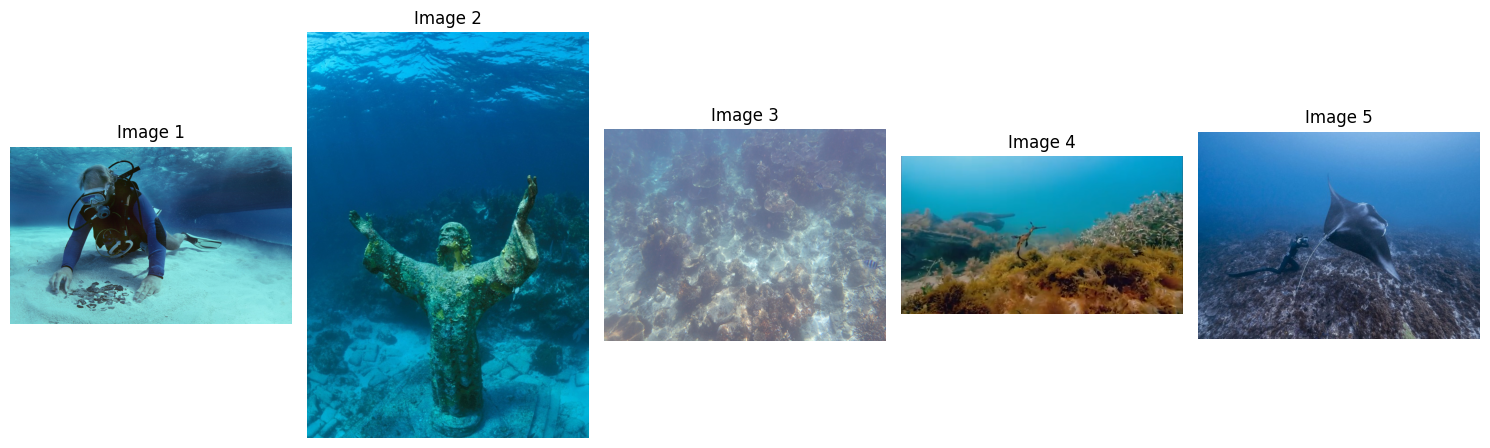

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Set dataset path
image_folder = "/content/drive/MyDrive/cv/cv"

# Load all image files
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

# Check if images exist
if not image_files:
    print("Error: No images found in dataset!")
else:
    print(f"Found {len(image_files)} images.")

# Display first 5 images from dataset
num_images_to_display = min(5, len(image_files))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    image = cv2.imread(image_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
def load_image(image_path):
    """Load and display the original image"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.1 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder found.
Found 5 images.


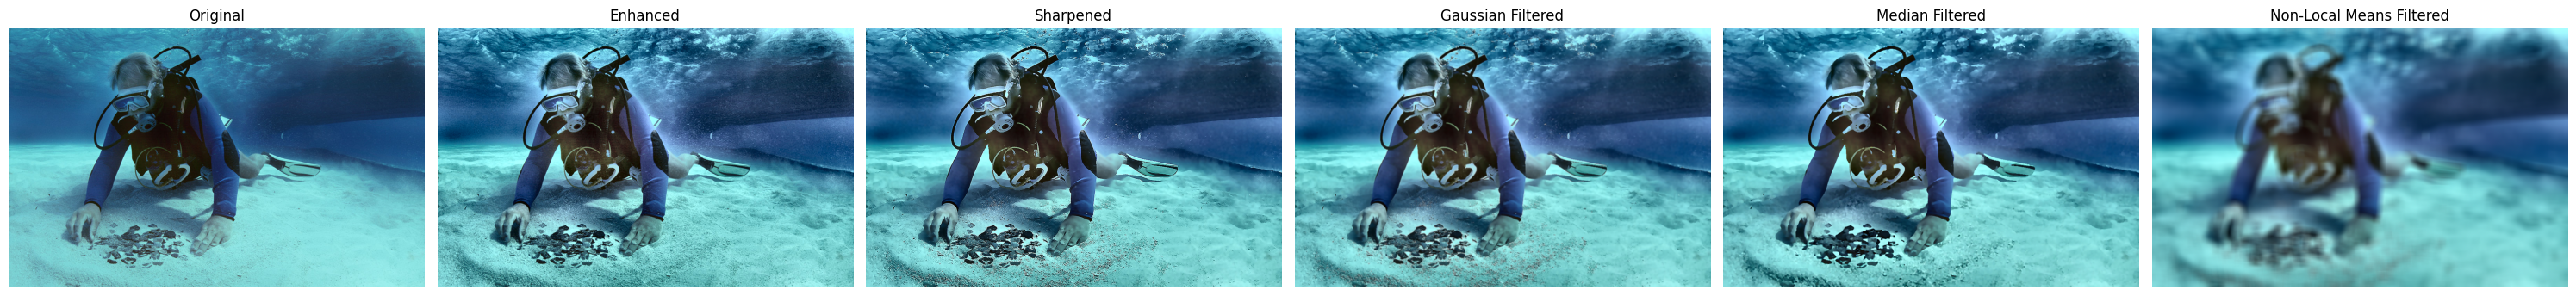

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Load Image Function
def load_image(image_path):
    """Load image and convert from BGR to RGB"""
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image is not None else None

# Apply Enhancement Filters
def enhance_image(image):
    """Apply filters to enhance image before processing"""
    # Convert to LAB and apply CLAHE for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l)
    enhanced_lab = cv2.merge((l_enhanced, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Apply Bilateral Filter for edge-preserving smoothing
    bilateral_filtered = cv2.bilateralFilter(enhanced_image, 9, 75, 75)

    # Apply Sharpening
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(bilateral_filtered, -1, sharpen_kernel)

    return {"Original": image, "Enhanced": enhanced_image, "Sharpened": sharpened}

# Apply Denoising Filters
def apply_filters(image):
    """Apply Gaussian, Median, and Non-Local Means Denoising"""
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)
    median_filtered = cv2.medianBlur(image, 5)

    sigma_est = np.mean(estimate_sigma(image, channel_axis=-1))
    nlm_filtered = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True, channel_axis=-1)

    return {"Gaussian Filtered": gaussian_filtered,
            "Median Filtered": median_filtered,
            "Non-Local Means Filtered": nlm_filtered}

# Set dataset path (Google Colab)
image_folder = "/content/drive/MyDrive/cv/cv"

# Check if folder exists
if not os.path.exists(image_folder):
    print("Error: Folder does not exist!")
    exit()
else:
    print("Folder found.")

# Load images
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

# Check if images were found
if not image_files:
    print("Error: No image files found in the folder!")
    exit()
else:
    print(f"Found {len(image_files)} images.")

# Process only if images are available
image_path = image_files[0]  # Use the first image
image = load_image(image_path)

if image is None:
    print("Error: Could not load the image!")
    exit()

# Apply Enhancements
enhanced_images = enhance_image(image)

# Apply Filters
filtered_images = apply_filters(enhanced_images["Sharpened"])

# Combine All Images for Display (Excluding Segmentation)
all_images = {**enhanced_images, **filtered_images}

# Display Results Dynamically
num_images = len(all_images)
fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

# Ensure `axes` is iterable (handles cases where only 1 image is available)
if num_images == 1:
    axes = [axes]

# Loop through available images and display them
for ax, (title, img) in zip(axes, all_images.items()):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from skimage.morphology import remove_small_objects, closing, square
from skimage.segmentation import felzenszwalb
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from sklearn.cluster import KMeans, MeanShift
from sklearn.utils import shuffle
from sklearn.metrics import jaccard_score
from skimage.util import img_as_ubyte
from scipy.ndimage import gaussian_filter
from sklearn.metrics import jaccard_score, f1_score  # IoU & Dice


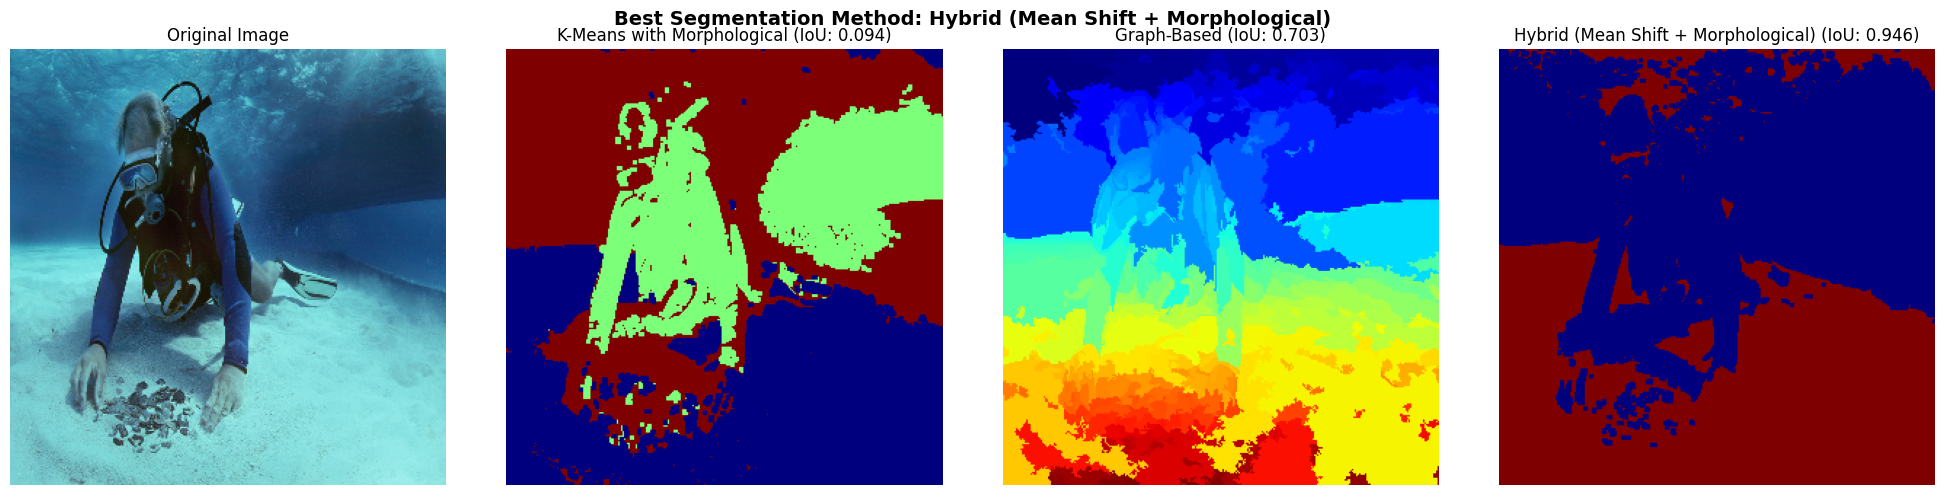

In [ ]:
# Suppress warnings
warnings.simplefilter("ignore")

# Load Image Function
def load_image(image_path):
    """Load image, resize for faster processing, and convert from BGR to RGB"""
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))  # Reduce resolution for efficiency
    return image

# K-Means with Morphological Processing
def kmeans_segmentation(image, n_clusters=3):
    """Apply K-Means clustering and refine with morphological operations."""
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixel_values)
    segmented_image = labels.reshape(image.shape[:2])

    # Apply Morphological Closing to refine
    refined_segmentation = closing(remove_small_objects(segmented_image, min_size=500), square(3))
    return refined_segmentation

# Mean Shift Segmentation
def mean_shift_segmentation(image):
    """Apply Mean Shift clustering for segmentation."""
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    subset = shuffle(pixel_values, random_state=42)[:len(pixel_values) // 10]
    mean_shift = MeanShift(bin_seeding=True)
    mean_shift.fit(subset)

    labels_mean_shift = mean_shift.predict(pixel_values)
    return labels_mean_shift.reshape(image.shape[:2])

# Graph-Based Segmentation
def graph_based_segmentation(image):
    """Apply Felzenszwalb's Graph-Based Segmentation."""
    graph_based = felzenszwalb(image, scale=50, sigma=0.5, min_size=20)
    return graph_based

# Hybrid: Mean Shift + Morphological Processing
def hybrid_segmentation(image):
    """Combine Mean Shift and Morphological Processing for segmentation."""
    mean_shift_result = mean_shift_segmentation(image)

    # Apply Morphological Closing to remove noise
    refined_segmentation = closing(remove_small_objects(mean_shift_result, min_size=500), square(3))

    return refined_segmentation

# Evaluate Segmentation with IoU (Intersection over Union)
def evaluate_segmentation(original_image, segmented_images):
    """Select the best segmentation using IoU score."""
    gray_image = rgb2gray(original_image)
    threshold = threshold_otsu(gray_image)
    ground_truth = (gray_image > threshold).astype(int)  # Create a binary reference

    scores = {}
    for method, segmented in segmented_images.items():
        segmented_bin = (segmented > np.mean(segmented)).astype(int)  # Convert to binary mask
        iou_score = jaccard_score(ground_truth.flatten(), segmented_bin.flatten())  # IoU Calculation
        scores[method] = iou_score

    best_method = max(scores, key=scores.get)
    return best_method, scores

# Set dataset path
image_folder = "/content/drive/MyDrive/cv/cv"  # Update path as needed
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

if not image_files:
    print("Error: No image files found in the folder!")
    exit()

image_path = image_files[0]
image = load_image(image_path)

if image is None:
    print("Error: Could not load the image!")
    exit()

# Apply Segmentation Methods
segmentations = {
    "K-Means with Morphological": kmeans_segmentation(image),

    "Graph-Based": graph_based_segmentation(image),
    "Hybrid (Mean Shift + Morphological)": hybrid_segmentation(image),
}

# Find Best Segmentation Method
best_method, scores = evaluate_segmentation(image, segmentations)

# Display Results
fig, axes = plt.subplots(1, len(segmentations) + 1, figsize=(20, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

for ax, (title, segmented) in zip(axes[1:], segmentations.items()):
    ax.imshow(segmented, cmap="jet")
    ax.set_title(f"{title} (IoU: {scores[title]:.3f})")
    ax.axis("off")

plt.suptitle(f"Best Segmentation Method: {best_method}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


Processing image...


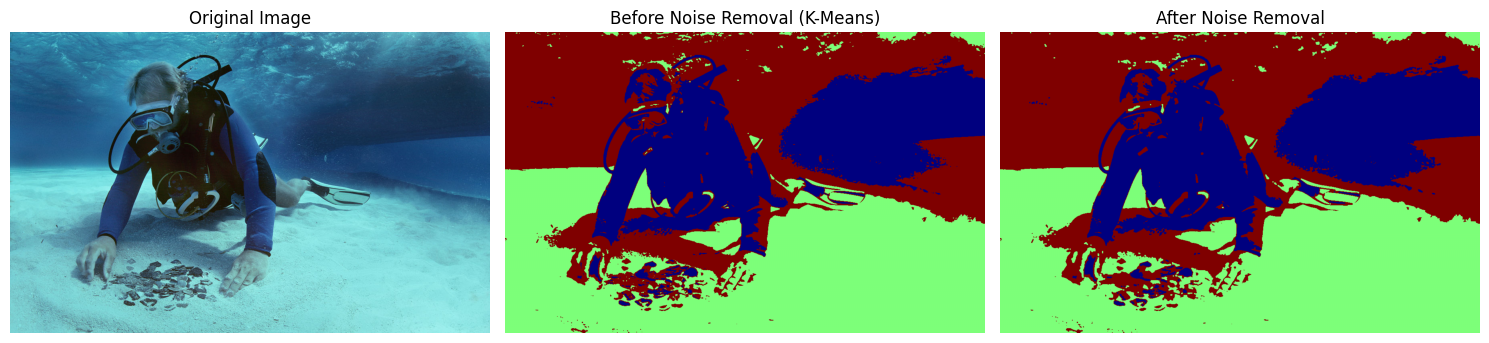

Processing complete!


In [ ]:
# --- Set Dataset Path ---
image_folder = "/content/drive/MyDrive/cv/cv"

# --- Load Image Function ---
def load_image(image_path):
    """Load image and convert from BGR to RGB"""
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image is not None else None

# --- Adaptive K-Means Segmentation ---
def kmeans_segmentation(image, n_clusters=3):
    """Apply K-Means clustering with preprocessing."""

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Flatten image and convert to float
    pixel_values = blurred.reshape((-1, 3)).astype(np.float32)

    # Use K-Means with optimal n_clusters if needed
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixel_values)

    # Reshape to original image shape
    segmented_image = labels.reshape(image.shape[:2])

    return segmented_image

# --- Region-Growing & Noise Removal ---
def region_based_processing(segmented_image, original_image):
    """Apply region-growing, remove small noisy regions, and enhance object separation."""

    # Compute dynamic min_size based on image size
    min_size = max(500, (segmented_image.shape[0] * segmented_image.shape[1]) // 2000)

    # Remove small noise using connected component analysis
    cleaned_segmentation = remove_small_objects(segmented_image, min_size=min_size)

    # Apply morphological closing to enhance object separation
    final_segmentation = closing(cleaned_segmentation, square(3))

    # --- Plot Comparison ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(img_as_ubyte(segmented_image), cmap="jet")
    axes[1].set_title("Before Noise Removal (K-Means)")
    axes[1].axis("off")

    axes[2].imshow(img_as_ubyte(final_segmentation), cmap="jet")
    axes[2].set_title("After Noise Removal")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return final_segmentation

# --- Load Dataset ---

image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))]



# --- Process First Image (For Testing) ---
image_path = image_files[0]
image = load_image(image_path)

if image is None:
    print("Error: Could not load the image!")
else:
    print("Processing image...")

    # --- K-Means Segmentation ---
    segmented_image = kmeans_segmentation(image)

    # --- Region-Based Processing ---
    final_result = region_based_processing(segmented_image, image)

    print("Processing complete!")


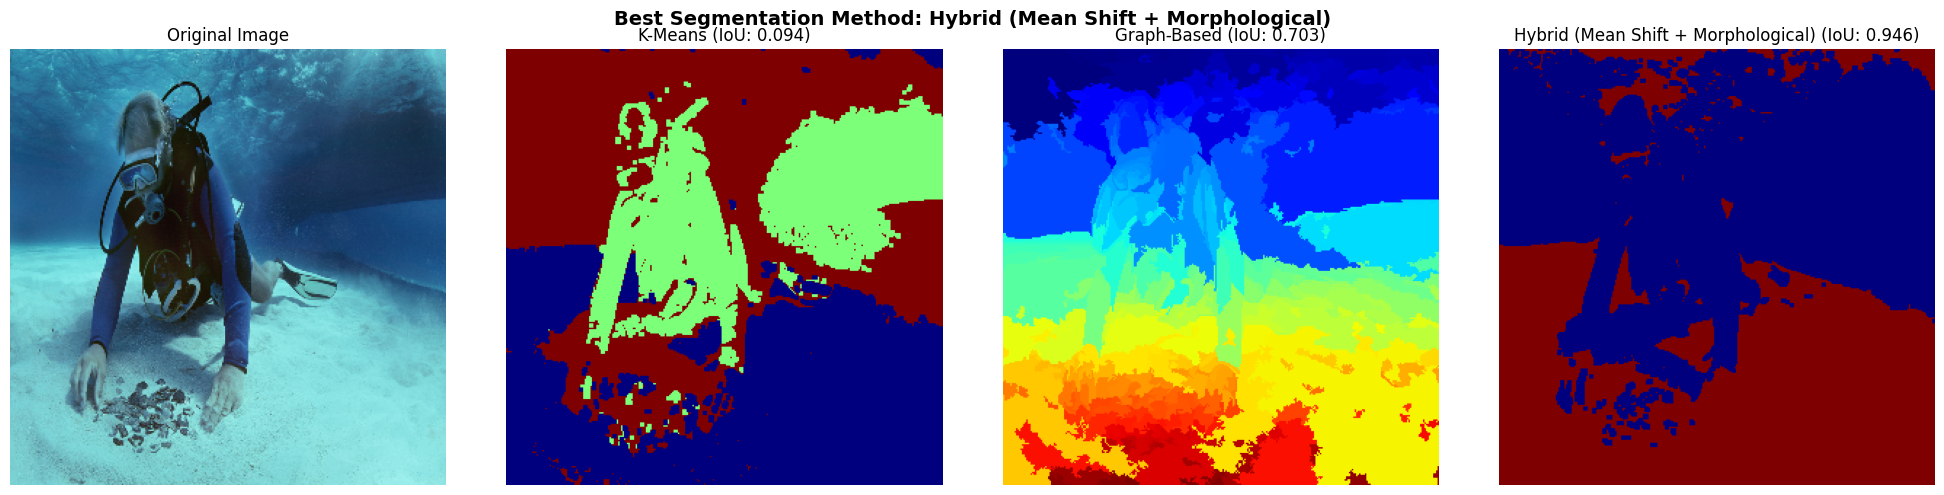


### Segmentation Performance Metrics ###

K-Means:
  - IoU: 0.094
  - Dice Coefficient: 0.172
  - Pixel Accuracy: 0.306

Graph-Based:
  - IoU: 0.703
  - Dice Coefficient: 0.826
  - Pixel Accuracy: 0.837

Hybrid (Mean Shift + Morphological):
  - IoU: 0.946
  - Dice Coefficient: 0.973
  - Pixel Accuracy: 0.976



In [ ]:
# Suppress warnings
warnings.simplefilter("ignore")

# Load Image Function
def load_image(image_path):
    """Load image, resize for faster processing, and convert from BGR to RGB"""
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))  # Reduce resolution for efficiency
    return image

# K-Means with Morphological Processing
def kmeans_segmentation(image, n_clusters=3):
    """Apply K-Means clustering and refine with morphological operations."""
    pixel_values = image.reshape((-1, 3)).astype(np.float32)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixel_values)
    segmented_image = labels.reshape(image.shape[:2])

    # Apply Morphological Closing to refine
    refined_segmentation = closing(remove_small_objects(segmented_image, min_size=500), square(3))
    return refined_segmentation

# Mean Shift Segmentation
def mean_shift_segmentation(image):
    """Apply Mean Shift clustering for segmentation."""
    pixel_values = image.reshape((-1, 3)).astype(np.float32)
    subset = shuffle(pixel_values, random_state=42)[:len(pixel_values) // 10]

    mean_shift = MeanShift(bin_seeding=True)
    mean_shift.fit(subset)

    labels_mean_shift = mean_shift.predict(pixel_values)
    return labels_mean_shift.reshape(image.shape[:2])

# Graph-Based Segmentation
def graph_based_segmentation(image):
    """Apply Felzenszwalb's Graph-Based Segmentation."""
    return felzenszwalb(image, scale=50, sigma=0.5, min_size=20)

# Hybrid: Mean Shift + Morphological Processing
def hybrid_segmentation(image):
    """Combine Mean Shift and Morphological Processing for segmentation."""
    mean_shift_result = mean_shift_segmentation(image)
    refined_segmentation = closing(remove_small_objects(mean_shift_result, min_size=500), square(3))
    return refined_segmentation

# Evaluation Metrics: IoU, Dice, and Pixel Accuracy
def evaluate_segmentation(original_image, segmented_images):
    """Evaluate segmentation using IoU, Dice Coefficient, and Pixel Accuracy."""
    gray_image = rgb2gray(original_image)
    threshold = threshold_otsu(gray_image)
    ground_truth = (gray_image > threshold).astype(int)  # Create a binary reference

    metrics = {}
    for method, segmented in segmented_images.items():
        segmented_bin = (segmented > np.mean(segmented)).astype(int)  # Convert to binary mask

        iou = jaccard_score(ground_truth.flatten(), segmented_bin.flatten())  # IoU
        dice = f1_score(ground_truth.flatten(), segmented_bin.flatten())  # Dice Coefficient
        pixel_acc = np.mean(ground_truth == segmented_bin)  # Pixel Accuracy

        metrics[method] = {"IoU": iou, "Dice": dice, "Pixel Accuracy": pixel_acc}

    best_method = max(metrics, key=lambda k: metrics[k]["IoU"])
    return best_method, metrics

# Set dataset path
image_folder = "/content/drive/MyDrive/cv/cv"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

if not image_files:
    print("Error: No image files found in the folder!")
    exit()

image_path = image_files[0]
image = load_image(image_path)

if image is None:
    print("Error: Could not load the image!")
    exit()

# Apply Segmentation Methods
segmentations = {
    "K-Means": kmeans_segmentation(image),

    "Graph-Based": graph_based_segmentation(image),
    "Hybrid (Mean Shift + Morphological)": hybrid_segmentation(image),
}

# Find Best Segmentation Method
best_method, scores = evaluate_segmentation(image, segmentations)

# Display Results
fig, axes = plt.subplots(1, len(segmentations) + 1, figsize=(20, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

for ax, (title, segmented) in zip(axes[1:], segmentations.items()):
    ax.imshow(segmented, cmap="jet")
    ax.set_title(f"{title} (IoU: {scores[title]['IoU']:.3f})")
    ax.axis("off")

plt.suptitle(f"Best Segmentation Method: {best_method}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print Evaluation Metrics
print("\n### Segmentation Performance Metrics ###\n")
for method, metrics in scores.items():
    print(f"{method}:")
    print(f"  - IoU: {metrics['IoU']:.3f}")
    print(f"  - Dice Coefficient: {metrics['Dice']:.3f}")
    print(f"  - Pixel Accuracy: {metrics['Pixel Accuracy']:.3f}\n")
